#  Dimensionality Reduction
*This is a notebook about Dimensionality Reduction*

## SETUP

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "chapter8_dim_reduction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [41]:
# Extra modules imported during the work
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import KernelPCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_swiss_roll
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

## PCA

In [3]:
# Build a simple 3D dataset
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

### Preserving the Variance


### Principal Components

In [4]:
# Find the principal components using Singular Value Decomposition (SVD)
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0] # 1st principal component
c2 = Vt.T[:, 1] # 2nd principal component

**Remark:** PCA assumes that the dataset is centered around the origin, which means the data should be centered before PCA implementation (sklearn will take care of it automatically).

In [5]:
# 1st principal component
c1

array([0.93636116, 0.29854881, 0.18465208])

In [6]:
# 2nd principal component
c2

array([-0.34027485,  0.90119108,  0.2684542 ])

### Projecting Down to d Dimensions

In [7]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2) # X in 2D plane using SVD
X2D_custom = X2D

### Using Scikit-Learn

In [8]:
# Implement PCA using SVD on the 3D dataset (sklearn)
pca = PCA(n_components=2)
X2D = pca.fit_transform(X) # automatically takes care of centering data
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [9]:
# Compare with the customized one
X2D_custom[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

**Remark:** Notice that running PCA multiple times on slightly different datasets may result in different results. In general the only difference is that some axes may be *flipped*. In this example, **PCA using Scikit-Learn gives the same projection as the one given by the SVD approach**, except both axes are flipped.

In [10]:
# Compare the results
np.allclose(X2D, -X2D_custom)

True

In [11]:
# Recover the 3D points projected on the plane from PCA 2D subspace 
X3D_inv = pca.inverse_transform(X2D)
X3D_inv[:5]

array([[-1.01450604, -0.54656333, -0.27441525],
       [-0.02103231,  0.55108376,  0.18101894],
       [-0.95379477, -0.4668077 , -0.24237013],
       [-0.91717404,  0.22083765, -0.01049779],
       [-0.74607229,  0.22027492,  0.00492637]])

In [12]:
# Compare the inverse transform to the origin
np.allclose(X3D_inv, X)

False

**Evaluate:** Some loss of information during the projection step is observed.

In [13]:
# Compute the reconstruction error
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.010170337792848549

In [14]:
# Access to the principal components computed 
pca.components_ 

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

**Remark:** PCs are expressed as horizontal vectors.

### Explained Variance Ratio

In [15]:
# Inspect the explained variance ratios of the 3D dataset
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

**Evaluate:** 
- 84.2% of the dataset’s variance lies along the first axis
- 14.6% lies along the second axis
- 1.1% for the third axis (Resonable to assume that this axis probably carries little information

In [16]:
# Compute the loss of variance by projecting down to 2D
1 - pca.explained_variance_ratio_.sum() # 1.1%

0.011195535570688975

### Choosing the Right Number of Dimensions

In [17]:
# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [18]:
# Split MNIST dataset
X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [19]:
# Compute the minimum number of dimensions required to preserve 95% of the training set’s variance
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

154

In [20]:
# Compute the minimum number of dimensions (easier)
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)
pca.n_components_

154

In [21]:
# Check the sum of the explained variance ratio
np.sum(pca.explained_variance_ratio_)

0.9503684424557428

Saving figure explained_variance_plot


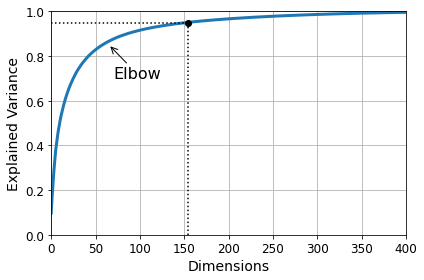

In [22]:
# Plot explained variance ratio as a function of the number of dimensions
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
save_fig("explained_variance_plot")
plt.show()

### PCA for Compression

In [23]:
# Reconstruct the data
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [24]:
# Setup to plot digits in MNIST dataset
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure mnist_compression_plot


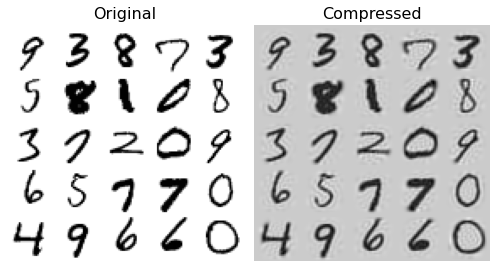

In [25]:
# Plot MNIST compression preserving 95% of the variance
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

save_fig("mnist_compression_plot")
plt.show()

**Evaluate:** Image quality loss slightly.

### Randomized PCA

In [26]:
# Perform Randomized PCA 
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

### Incremental PCA

In [27]:
# Perform IPCA
n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="")
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [28]:
# Create the memmap() structure and copy the MNIST data into it
filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

In [29]:
# Deleting the memmap() object
del X_mm

In [30]:
# Load partially back the saved data
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm) # possible to use fit now

IncrementalPCA(batch_size=525, n_components=154)

## Kernel PCA

In [31]:
# Create a Swiss roll dataset
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [32]:
# Perform Kernel PCA on the Swiss roll dataset
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

Saving figure kernel_pca_plot


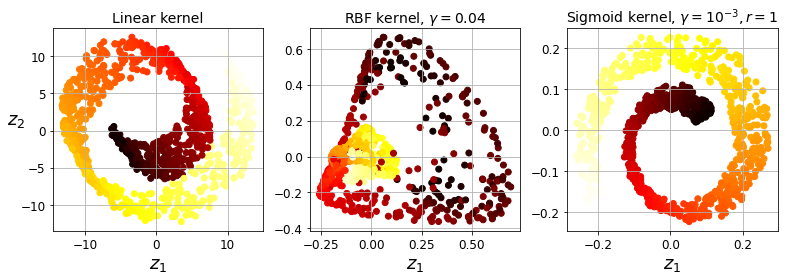

In [33]:
# Plot the Swiss roll reduced to 2D using kPCA with different kernels
lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("kernel_pca_plot")
plt.show()

### Selecting a Kernel and Tuning Hyperparameters

In [34]:
# Use grid search to select the kernel and hyperparameters
clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [35]:
# The best kernel and hyperparameters
grid_search.best_params_

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}

In [36]:
# Perform the reconstruction pre-image
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [37]:
# Compute the reconstruction pre-image error
mean_squared_error(X, X_preimage)

32.78630879576611

## LLE

In [38]:
# Create a Swiss roll dataset
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [39]:
# Perform LLE on the Swiss roll dataset
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

Saving figure lle_unrolling_plot


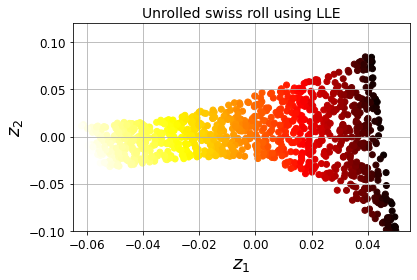

In [40]:
# Plot the unrolled Swiss roll using LLE
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

save_fig("lle_unrolling_plot")
plt.show()

## Other Dimensionality Reduction Techniques

In [42]:
# Perform Multidimensional Scaling (MDS)
mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

In [43]:
# Peform Isomap
isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [44]:
# Perform t-Distributed Stochastic Neighbor Embedding (t-SNE)
tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [45]:
# Perform Linear Discriminant Analysis (LDA)
lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

Saving figure other_dim_reduction_plot


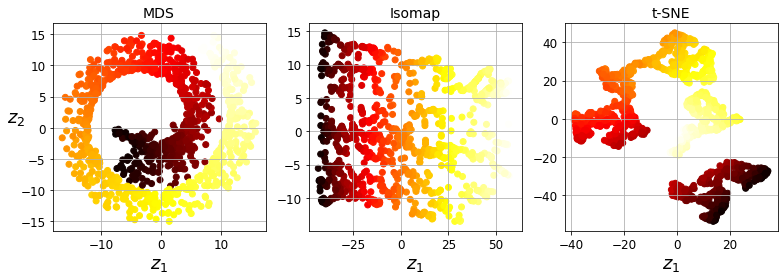

In [46]:
# Plot various techniques' implementation to reduce the Swill roll to 2D
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("other_dim_reduction_plot")
plt.show()